# Introduction

This is a map-reduce version of expectation maximization algo for a mixture of Gaussians model. There are two mrJob MR packages, mr_GMixEmIterate and mr_GMixEmInitialize.  The driver calls the mrJob packages and manages the iteration. 

## E Step: Given priors, mean vector and covariance matrix, calculate the probability of that each data point belongs to a class 

\begin{equation}
p\left(\omega_k|\mathbf{x}^{(i)},\theta\right)=
\frac{\pi_k\mathcal{N}\left(\mathbf{x}^{(i)} \mid \mathbf{\mu}_k,\mathbf{\Sigma}_k\right)}
     {\sum_{j=1}^K \pi_j\mathcal{N}\left(\mathbf{x}^{(i)}\mid \mathbf{\mu}_j,\mathbf{\Sigma}_j\right)}
\end{equation}

## M Step: Given probabilities, update priors, mean and covariance

 \begin{align}
\mathbf{\hat{\mu}}_k & = \frac{1}{n_k}\sum_{i=1}^n p(\omega_k\mid\mathbf{x}^{(i)},\theta)\mathbf{x}^{(i)} \\ 
\mathbf{\hat{\Sigma}}_k & = \frac{1}{n_k}\sum_{i=1}^n p(\omega_k\mid\mathbf{x}^{(i)},\theta)(\mathbf{x}^{(i)}-\mathbf{\hat{\mu}}_k)(\mathbf{x}^{(i)}-\mathbf{\hat{\mu}}_k)^T \\ 
\hat{\pi}_k & = \frac{n_k}{n} \mbox{ where } n_k=\sum_{i=1}^n p(\omega_k\mid\mathbf{x}^{(i)},\theta)
\end{align}

# Data Generation

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import json
size = 1000

s1=np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size)
s2=np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size)
s3=np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size)
data = np.vstack((s1,s2,s3))

# Randomize data
data = np.random.permutation(data)
with open("data.txt", "w") as f:
    for row in data.tolist():
        json.dump(row, f)
        f.write("\n")

/opt/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Data Visualiazation

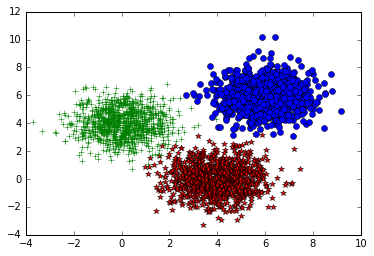

In [2]:
plt.plot(s1[:, 0], s1[:, 1],'*', color = 'red')
plt.plot(s2[:, 0], s2[:, 1],'o',color = 'blue')
plt.plot(s3[:, 0], s3[:, 1],'+',color = 'green')
plt.show()

# Initialization

Here suppose we know there are 3 components

In [39]:
%%writefile mr_GMixEmInitialize.py
#!/opt/anaconda/bin/python
from mrjob.job import MRJob

from numpy import mat, zeros, shape, random, array, zeros_like, dot, linalg, diag
import json
from math import pi, sqrt, exp, pow
import sys


class MrGMixEmInit(MRJob):
    DEFAULT_PROTOCOL = 'json'
    
    def __init__(self, *args, **kwargs):
        super(MrGMixEmInit, self).__init__(*args, **kwargs)
        
        self.numMappers = 1     #number of mappers
        self.count = 0
        
                                                 
    def configure_options(self):
        super(MrGMixEmInit, self).configure_options()
        self.add_passthrough_option(
            '--k', dest='k', default=3, type='int',
            help='k: number of densities in mixture')
        self.add_passthrough_option(
            '--pathName', dest='pathName', default="", type='str',
            help='pathName: pathname where intermediateResults.txt is stored')
        
    def mapper(self, key, xjIn):
        #something simple to grab random starting point
        #collect the first 2k
        if self.count <= 2*self.options.k:
            self.count += 1
            yield (1,xjIn)        
        
    def reducer(self, key, xjIn):        
        #accumulate data points mapped to 0 from 1st mapper and pull out k of them as starting point
        cent = []
        for xj in xjIn:
            x = json.loads(xj)
            cent.append(x)
            yield 1, xj
        cent2 = array([cent[i] for i in random.randint(0, len(cent), self.options.k)], dtype=float)
            
        #use the covariance of the selected centers as the starting guess for covariances
        #first, calculate mean of centers
        mean = cent2.mean(axis=0)
        
        #then accumulate the deviations
        cov=diag(((cent-mean)**2).sum(axis=0))/self.options.k
        covInv = linalg.inv(cov)
        cov_1 = [covInv.tolist()]*self.options.k

        jDebug = json.dumps([cent2.tolist(),mean.tolist(),cov.tolist(),covInv.tolist(),cov_1])    
        debugPath = self.options.pathName + 'debug.txt'
        with open(debugPath,'w') as fileOut:
            fileOut.write(jDebug)
        
        #also need a starting guess at the phi's - prior probabilities
        #initialize them all with the same number - 1/k - equally probably for each cluster        
        phi=array([1.0/self.options.k]*self.options.k)
        
        #form output object
        jsonOut  = json.dumps({
                'phi': phi.tolist(), 
                'means': cent2.tolist(),
                'cov': cov_1
            })
        
        print >>sys.stderr, "Writing", jsonOut
        #write new parameters to file
        fullPath = self.options.pathName + 'intermediateResults.txt'
        with open(fullPath,'w') as fileOut:
            fileOut.write(jsonOut)

if __name__ == '__main__':
    MrGMixEmInit.run()

Overwriting mr_GMixEmInitialize.py


# Iteration

**Mapper** – each mapper needs k vector means and covariance matrices to make probability calculations.  Can also accumulate partial sum (sum restricted to the mapper's input) of quantities required for update.  Then it emits partial sum as single output from combiner.  
    Emit (dummy_key, partial_sum_for_all_k's)

**Reducer** –the iterator pulls in the partial sum for all k's from all the mappers and combines in a single reducer.  In this case the reducer emits a single (json'd python object) with the new means and covariances.


In [58]:
%%writefile mr_GMixEmIterate.py
#!/opt/anaconda/bin/python
from mrjob.job import MRJob

from math import sqrt, exp, pow,pi
from numpy import zeros, shape, random, array, zeros_like, dot, linalg, meshgrid
import json
import sys

def gauss(x, mu, P_1):
    xtemp = x - mu
    n = len(x)
    p = exp(- 0.5*dot(xtemp,dot(P_1,xtemp)))
    detP = 1/linalg.det(P_1)
    p = p/(pow(2.0*pi,n/2.0)*sqrt(detP))
    return p

class MrGMixEm(MRJob):
    DEFAULT_PROTOCOL = 'json'
    
    def __init__(self, *args, **kwargs):
        super(MrGMixEm, self).__init__(*args, **kwargs)
        
        fullPath = self.options.pathName + 'intermediateResults.txt'
        with open(fullPath) as fileIn:
            inputJson = fileIn.read()
        inputList = json.loads(inputJson)
        self.phi = array(inputList['phi'])     #prior class probabilities
        self.means = array(inputList['means']) #current means list
        self.cov_1 = array(inputList['cov'])   #inverse covariance matrices for w, calc.
        #accumulate partial sums                               
        #sum of weights - by cluster
        self.new_phi = zeros_like(self.phi)        #partial weighted sum of weights
        self.new_means = zeros_like(self.means)
        self.new_cov = zeros_like(self.cov_1)
        
        self.numMappers = 1             #number of mappers
        self.count = 0                  #passes through mapper
        
                                                 
    def configure_options(self):
        super(MrGMixEm, self).configure_options()

        self.add_passthrough_option(
            '--k', dest='k', default=3, type='int',
            help='k: number of densities in mixture')
        self.add_passthrough_option(
            '--pathName', dest='pathName', default="", type='str',
            help='pathName: pathname where intermediateResults.txt is stored')
        
    def mapper(self, key, val):
        #accumulate partial sums for each mapper
        xList = json.loads(val)
        x = array(xList)
        wtVect = zeros_like(self.phi)
        for i in range(self.options.k):
            wtVect[i] = self.phi[i]*gauss(x,self.means[i],self.cov_1[i])
        wtSum = sum(wtVect)
        wtVect = wtVect/wtSum
        #accumulate to update est of probability densities.
        #increment count
        self.count += 1
        #accumulate weights for phi est
        self.new_phi = self.new_phi + wtVect
        for i in range(self.options.k):
            #accumulate weighted x's for mean calc
            self.new_means[i] = self.new_means[i] + wtVect[i]*x
            #accumulate weighted squares for cov estimate
            xmm = x - self.means[i]
            l,r=meshgrid(xmm, xmm)
            self.new_cov[i] += wtVect[i]*l*r
        #dummy yield - real output passes to mapper_final in self

        
    def mapper_final(self):
        jOut = json.dumps({
                'count': self.count,
                'phi': self.new_phi.tolist(),
                'means': self.new_means.tolist(),
                'cov': self.new_cov.tolist()
            })
        yield 1,jOut
    
    
    def reducer(self, key, xs):
        #accumulate partial sums
        #xs us a list of paritial stats, including count, phi, mean, and covariance. 
        #Each stats is k-length array, storing info for k components
        totCount=0
        totPhi=zeros_like(self.phi)
        totMeans=zeros_like(self.means)
        totCov=zeros_like(self.cov_1)
        for valStr in xs:
            val = json.loads(valStr)
            totCount += val['count']
            totPhi   += array(val['phi'])
            totMeans += array(val['means'])
            totCov   += array(val['cov'])
        #finish calculation of new probability parameters. array divided by array
        newPhi = totPhi/totCount
        #initialize these to something handy to get the right size arrays
        newMeans = totMeans
        newCov_1 = totCov
        for i in range(self.options.k):
            newMeans[i,:] = totMeans[i,:]/totPhi[i]
            tempCov = totCov[i,:,:]/totPhi[i]
            #almost done.  just need to invert the cov matrix.  invert here to save doing a matrix inversion
            #with every input data point.
            newCov_1[i,:,:] = linalg.inv(tempCov)
        
        jsonOut = json.dumps({
                'phi': newPhi.tolist(),
                'means': newMeans.tolist(),
                'cov': newCov_1.tolist()
        })
        
        #write new parameters to file
        fullPath = self.options.pathName + 'intermediateResults.txt'
        with open(fullPath,'w') as fileOut:
            fileOut.write(jsonOut)

if __name__ == '__main__':
    MrGMixEm.run()

Overwriting mr_GMixEmIterate.py


# Driver

In [44]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0-Iteration 0


Writing {"phi": [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], "cov": [[[0.023296152958760728, 0.0], [0.0, 0.027515866400150458]], [[0.023296152958760728, 0.0], [0.0, 0.027515866400150458]], [[0.023296152958760728, 0.0], [0.0, 0.027515866400150458]]], "means": [[7.136899533512323, 5.570119631860332], [-1.8967175691061544, 4.502054842879402], [4.332703200719853, -1.097088054049692]]}


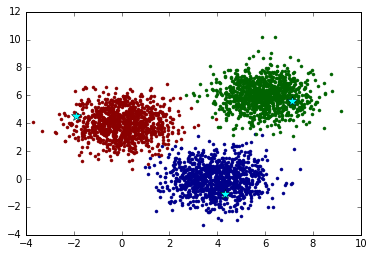

0-Iteration 1


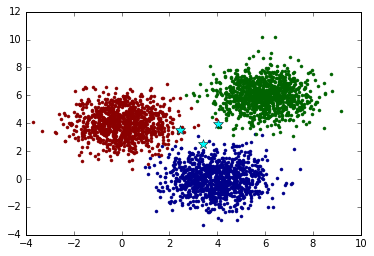

0-Iteration 2


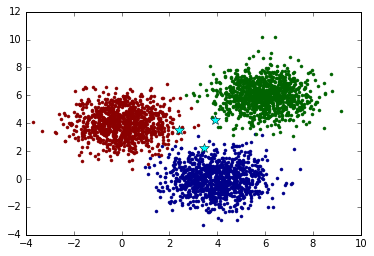

0-Iteration 3


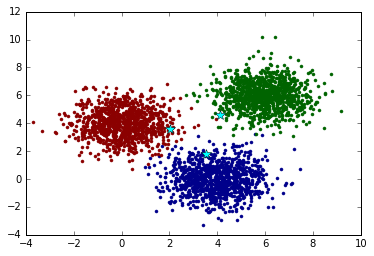

0-Iteration 4


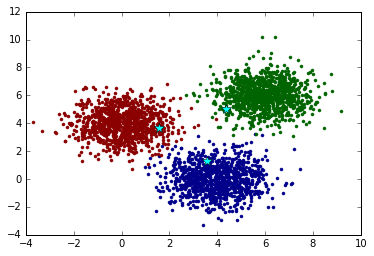

0-Iteration 5


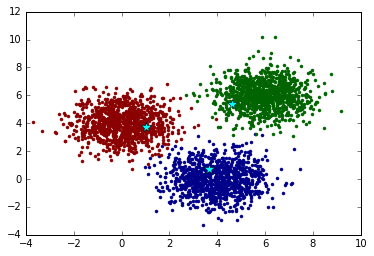

0-Iteration 6


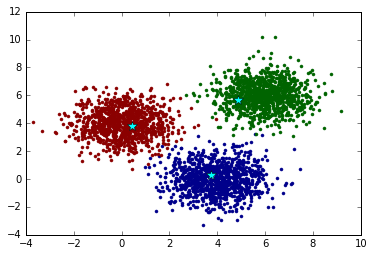

0-Iteration 7


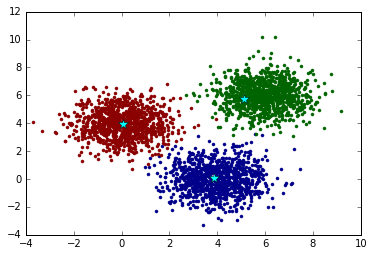

0-Iteration 8


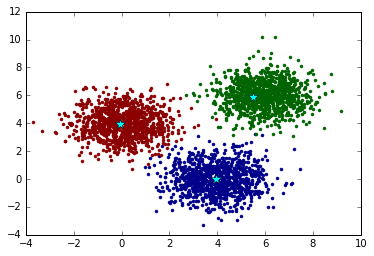

0-Iteration 9


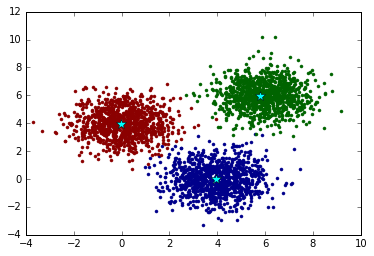

0-Iteration 10


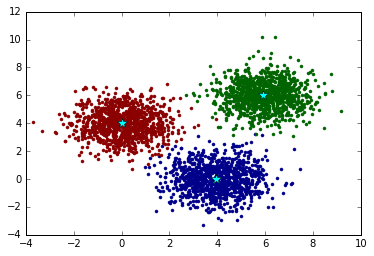

0-Iteration 11


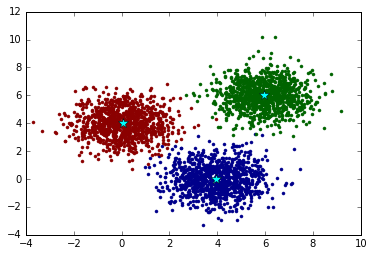

5-Iteration 12
6-newMeans [[5.94370950620592, 6.008505885405597], [0.04322359009852737, 4.005642896751613], [3.955647992497198, -0.006240036099158569]]


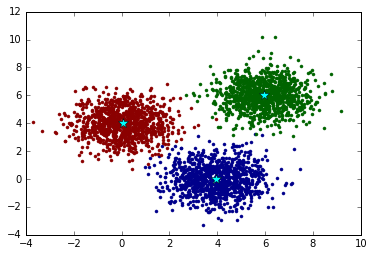

In [60]:
%autoreload 2
from mr_GMixEmInitialize import MrGMixEmInit
from mr_GMixEmIterate import MrGMixEm
import json
from math import sqrt
from os import getcwd
import matplotlib.pyplot as plt

def plot_iteration(means):
    plt.plot(s1[:, 0], s1[:, 1], '.', color = 'darkblue',marker='.')
    plt.plot(s2[:, 0], s2[:, 1], '.', color = 'darkgreen',marker='.')
    plt.plot(s3[:, 0], s3[:, 1],'.', color = 'darkred',marker='.')
    plt.plot(means[0][0], means[0][1],'*',markersize =10,color = 'cyan')
    plt.plot(means[1][0], means[1][1],'*',markersize =10,color = 'cyan')
    plt.plot(means[2][0], means[2][1],'*',markersize =10,color = 'cyan')
    plt.show()

def dist(x,y):
    #euclidean distance between two lists    
    sum = 0.0
    for i in range(len(x)):
        temp = x[i] - y[i]
        sum += temp * temp
    return sqrt(sum)

#first run the initializer to get starting centroids
filePath = 'data.txt'
mrJob = MrGMixEmInit(args=[filePath, '--pathName', getcwd()+'/', filePath])
with mrJob.make_runner() as runner:
    runner.run()

#pull out the centroid values to compare with values after one iteration
emPath = "intermediateResults.txt"
with open(emPath) as fileIn:
    paramJson = fileIn.read()


delta = 10
iter_num = 0
#Begin iteration on change in centroids
while delta > 0.02:
    print "0-Iteration", iter_num
    iter_num = iter_num + 1
    #parse old centroid values
    oldParam = json.loads(paramJson)
    #run one iteration
    oldMeans = oldParam['means']
    mrJob2 = MrGMixEm(args=[filePath,'--pathName', getcwd()+'/', filePath])
    with mrJob2.make_runner() as runner:
        runner.run()

    #compare new centroids to old ones
    with open(emPath) as fileIn:
        paramJson = fileIn.read()
    newParam = json.loads(paramJson)
    newMeans = newParam['means']
    k_means = len(newMeans)

    delta = 0.0
    for i in range(k_means):
        delta += dist(newMeans[i],oldMeans[i])

    plot_iteration(oldMeans)
print "5-Iteration", iter_num
print "6-newMeans", newMeans
plot_iteration(newMeans)